In [6]:
import os
import urllib.request
import tarfile
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
from pathlib import Path
import requests
from tqdm import tqdm
import glob


# Using LFW Dataset to test

In [13]:
class LFWDatasetSetup:
    def __init__(self):
        self.base_dir = 'data/lfw'
        self.images_dir = 'data/lfw/lfw-deepfunneled'
            
    
    def scan_images(self):
        """Scan and catalog all images"""
        if not os.path.exists(self.images_dir):
            print("❌ Images directory not found. Please extract dataset first.")
            return None
        
        print("🔍 Scanning images...")
        
        # Find all JPEG images
        image_paths = []
        for root, dirs, files in os.walk(self.images_dir):
            for file in files:
                if file.lower().endswith(('.jpg', '.jpeg', '.png')):
                    full_path = os.path.join(root, file)
                    relative_path = os.path.relpath(full_path, self.images_dir)
                    image_paths.append(relative_path)
        
        print(f"✅ Found {len(image_paths)} images")
        
        annotations = {}
        for img_path in image_paths:
            full_path = os.path.join(self.images_dir, img_path)
            if os.path.exists(full_path):
                try:
                    # Load image to get dimensions
                    img = cv2.imread(full_path)
                    if img is not None:
                        h, w = img.shape[:2]
                        # For LFW, assume the whole image is roughly a face
                        # Add some padding (10% margin)
                        margin = 0.1
                        x = int(w * margin)
                        y = int(h * margin)
                        face_w = int(w * (1 - 2*margin))
                        face_h = int(h * (1 - 2*margin))
                        
                        annotations[img_path] = [{
                            'bbox': [x, y, face_w, face_h],
                            'confidence': 1.0,  # High confidence since these are curated faces
                            'type': 'single_face'
                        }]
                except Exception as e:
                    print(f"⚠️ Could not process {img_path}: {e}")
                    continue
        
        print(f"✅ Created annotations for {len(annotations)} images")
        return annotations
    
    def visualize_samples(self, annotations, num_samples=6):
        if not annotations:
            print("❌ No annotations to visualize")
            return
        
        sample_images = list(annotations.keys())[:num_samples]
        
        fig, axes = plt.subplots(2, 3, figsize=(15, 10))
        axes = axes.flatten()
        
        for idx, img_path in enumerate(sample_images):
            full_img_path = os.path.join(self.images_dir, img_path)
            
            if os.path.exists(full_img_path):
                img = cv2.imread(full_img_path)
                img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                
                # Draw bounding box
                for face in annotations[img_path]:
                    x, y, w, h = face['bbox']
                    cv2.rectangle(img_rgb, (x, y), (x+w, y+h), (255, 0, 0), 2)
                
                axes[idx].imshow(img_rgb)
                axes[idx].set_title(f'Image {idx+1}')
                axes[idx].axis('off')
            else:
                axes[idx].text(0.5, 0.5, 'Image not found', ha='center', va='center')
                axes[idx].set_title('Missing')
        
        plt.suptitle('LFW Dataset Sample Images with Face Annotations')
        plt.tight_layout()
        plt.show()
    
    def create_test_split(self, annotations, test_ratio=0.2):
        """Create train/test split for evaluation"""
        image_paths = list(annotations.keys())
        np.random.shuffle(image_paths)
        
        split_idx = int(len(image_paths) * (1 - test_ratio))
        train_paths = image_paths[:split_idx]
        test_paths = image_paths[split_idx:]
        
        train_annotations = {path: annotations[path] for path in train_paths}
        test_annotations = {path: annotations[path] for path in test_paths}
        
        print(f"📊 Dataset split:")
        print(f"  Training images: {len(train_annotations)}")
        print(f"  Testing images: {len(test_annotations)}")
        
        return train_annotations, test_annotations
    
    def get_dataset_statistics(self, annotations):
        if not annotations:
            print("❌ No annotations to analyze")
            return
        
        total_images = len(annotations)
        total_faces = sum(len(faces) for faces in annotations.values())
        
    
        dimensions = []
        face_sizes = []
        
        sample_images = list(annotations.keys())[:100]  # Sample for stats
        
        for img_path in sample_images:
            full_path = os.path.join(self.images_dir, img_path)
            if os.path.exists(full_path):
                img = cv2.imread(full_path)
                if img is not None:
                    h, w = img.shape[:2]
                    dimensions.append((w, h))
                    
                    for face in annotations[img_path]:
                        face_w, face_h = face['bbox'][2], face['bbox'][3]
                        face_sizes.append(face_w * face_h)
        
        print(f"\n📈 LFW Dataset Statistics:")
        print(f"  Total images: {total_images}")
        print(f"  Total faces: {total_faces}")
        print(f"  Faces per image: {total_faces/total_images:.2f}")
        
        if dimensions:
            avg_w = np.mean([d[0] for d in dimensions])
            avg_h = np.mean([d[1] for d in dimensions])
            print(f"  Average image size: {avg_w:.0f} x {avg_h:.0f}")
        
        if face_sizes:
            print(f"  Average face area: {np.mean(face_sizes):.0f} pixels")
    
    def setup_complete_dataset(self, visualize=False):
        """Complete setup process"""
        print("🚀 Setting up LFW dataset for single-face detection testing...")
                        
        # Step 4: Scan and create annotations
        annotations = self.scan_images()
        if not annotations:
            return None, None
        
        # Step 5: Statistics
        self.get_dataset_statistics(annotations)
        
        # Step 6: Visualize samples
        if visualize:
            self.visualize_samples(annotations)
        
        # Step 7: Create train/test split
        train_annotations, test_annotations = self.create_test_split(annotations)
        
        print("✅ LFW dataset setup complete!")
        print(f"📍 Images location: {self.images_dir}")
        
        return test_annotations, self.images_dir
    

## Deepface Detector Class

In [14]:
import os
import cv2
import time
import numpy as np
import pandas as pd
from deepface import DeepFace
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import warnings
warnings.filterwarnings('ignore')

class DeepFaceDetectorTest:
    def __init__(self, test_annotations, images_dir):
        """
        Initialize with LFW test data
        
        Args:
            test_annotations: Dictionary from LFWDatasetSetup.setup_complete_dataset()
            images_dir: Images directory path from LFWDatasetSetup
        """
        self.test_annotations = test_annotations
        self.images_dir = images_dir
        # List all available detectors in DeepFace
        self.detectors = ["opencv", "mtcnn", "retinaface", "ssd", "yunet", "centerface"]
        self.results = {}
    
    def test_single_detector(self, detector_name, max_images=50):
        """Test a single detector's speed and efficiency"""
        print(f"\n🔍 Testing {detector_name} detector...")
        
        results = {
            'detector': detector_name,
            'total_images': 0,
            'successful_detections': 0,
            'detection_times': [],
            'faces_detected': [],
            'errors': 0
        }
        
        # Sample images for testing
        test_images = list(self.test_annotations.keys())[:max_images]
        
        for idx, img_path in enumerate(test_images):
            if idx % 20 == 0:
                print(f"  Progress: {idx}/{len(test_images)} images processed")
            
            full_img_path = os.path.join(self.images_dir, img_path)
            
            if not os.path.exists(full_img_path):
                continue
                
            results['total_images'] += 1
            
            try:
                # Time the detection
                start_time = time.time()
                
                # Detect faces using DeepFace
                detections = DeepFace.extract_faces(
                    img_path=full_img_path,
                    detector_backend=detector_name,
                    enforce_detection=False,
                    align=False
                )
                
                detection_time = time.time() - start_time
                results['detection_times'].append(detection_time)
                results['faces_detected'].append(len(detections))
                
                # Count successful detections
                if len(detections) > 0:
                    results['successful_detections'] += 1
                    
            except Exception as e:
                results['errors'] += 1
        
        # Calculate metrics
        avg_time = np.mean(results['detection_times']) if results['detection_times'] else 0
        success_rate = results['successful_detections'] / results['total_images'] if results['total_images'] > 0 else 0
        avg_faces = np.mean(results['faces_detected']) if results['faces_detected'] else 0
        throughput = 1.0 / avg_time if avg_time > 0 else 0  # Images per second
        
        results['avg_detection_time'] = avg_time
        results['success_rate'] = success_rate
        results['avg_faces_per_image'] = avg_faces
        results['throughput'] = throughput
        results['error_rate'] = results['errors'] / results['total_images'] if results['total_images'] > 0 else 0
        
        print(f"  ✅ {detector_name} completed:")
        print(f"    - Avg Detection Time: {avg_time:.3f}s")
        print(f"    - Throughput: {throughput:.2f} images/sec")
        print(f"    - Success Rate: {success_rate:.3f}")
        print(f"    - Error Rate: {results['error_rate']:.3f}")
        
        return results
    
    def test_all_detectors(self, max_images=50):
        """Test all detectors and collect results"""
        print("STARTING DEEPFACE DETECTOR PERFORMANCE TEST")
        print("="*60)
        print(f"🚀 Starting comprehensive detector testing...")
        print(f"📊 Testing on {min(max_images, len(self.test_annotations))} images")
        
        for detector in self.detectors:
            try:
                self.results[detector] = self.test_single_detector(detector, max_images)
            except Exception as e:
                print(f"❌ Failed to test {detector}: {e}")
                continue
        
        print("\n✅ All detector testing completed!")
        return self.results
    
    def create_performance_plots(self):
        """Create performance visualization focusing on speed and efficiency"""
        if not self.results:
            print("❌ No results to plot. Run test_all_detectors() first.")
            return
        
        # Prepare data for plotting
        detectors = list(self.results.keys())
        metrics_data = {
            'Detector': detectors,
            'Avg Detection Time (s)': [self.results[d]['avg_detection_time'] for d in detectors],
            'Throughput (img/sec)': [self.results[d]['throughput'] for d in detectors],
            'Success Rate': [self.results[d]['success_rate'] for d in detectors],
            'Error Rate': [self.results[d]['error_rate'] for d in detectors],
            'Avg Faces Detected': [self.results[d]['avg_faces_per_image'] for d in detectors],
        }
        
        # Create subplots
        fig = make_subplots(
            rows=2, cols=2,
            subplot_titles=('Detection Speed', 'Throughput (Images/sec)', 
                           'Success & Error Rates', 'Memory Usage Distribution'),
            specs=[[{"secondary_y": False}, {"secondary_y": False}],
                   [{"secondary_y": True}, {"secondary_y": False}]]
        )
        
        # 1. Detection Speed (Bar chart)
        fig.add_trace(
            go.Bar(name='Avg Detection Time', x=detectors, 
                   y=metrics_data['Avg Detection Time (s)'],
                   marker_color='lightblue', showlegend=True),
            row=1, col=1
        )
        
        # 2. Throughput
        fig.add_trace(
            go.Bar(name='Throughput', x=detectors, 
                   y=metrics_data['Throughput (img/sec)'],
                   marker_color='lightgreen', showlegend=True),
            row=1, col=2
        )
        
        # 3. Success & Error Rates
        fig.add_trace(
            go.Bar(name='Success Rate', x=detectors, y=metrics_data['Success Rate'],
                   marker_color='lightcoral', showlegend=True),
            row=2, col=1
        )
        
        fig.add_trace(
            go.Bar(name='Error Rate', x=detectors, y=metrics_data['Error Rate'],
                   marker_color='gold', showlegend=True),
            row=2, col=1, secondary_y=True
        )
        
        # 4. Efficiency Scatter Plot - Throughput vs Success Rate
        fig.add_trace(
            go.Scatter(
                x=metrics_data['Throughput (img/sec)'],
                y=metrics_data['Success Rate'],
                mode='markers+text',
                text=detectors,
                textposition="top center",
                marker=dict(
                    size=15, 
                    color=metrics_data['Avg Detection Time (s)'],
                    colorscale='Viridis', 
                    showscale=True,
                    colorbar=dict(title="Detection Time (s)")
                ),
                name='Efficiency Plot',
            ),
            row=2, col=2
        )
        
        # Update layout
        fig.update_layout(
            title_text="DeepFace Detector Speed & Efficiency Analysis",
            title_font_size=16,
            showlegend=True,
            height=800,
            width=1200
        )
        
        # Update axes labels
        fig.update_xaxes(title_text="Detectors", row=1, col=1)
        fig.update_yaxes(title_text="Time (seconds)", row=1, col=1)
        fig.update_xaxes(title_text="Detectors", row=1, col=2)
        fig.update_yaxes(title_text="Images per second", row=1, col=2)
        fig.update_xaxes(title_text="Detectors", row=2, col=1)
        fig.update_yaxes(title_text="Success Rate", row=2, col=1)
        fig.update_yaxes(title_text="Error Rate", row=2, col=1, secondary_y=True)
        fig.update_xaxes(title_text="Throughput (images/sec)", row=2, col=2)
        fig.update_yaxes(title_text="Success Rate", row=2, col=2)
        
        fig.show()
        
        # Create detailed comparison table
        self.create_detailed_table()
    
    def create_detailed_table(self):
        """Create a detailed comparison table for speed metrics"""
        if not self.results:
            return
        
        # Prepare detailed data
        table_data = []
        for detector, result in self.results.items():
            table_data.append({
                'Detector': detector,
                'Total Images': result['total_images'],
                'Successful Detections': result['successful_detections'],
                'Avg Detection Time (s)': f"{result['avg_detection_time']:.3f}",
                'Throughput (img/sec)': f"{result['throughput']:.2f}",
                'Success Rate': f"{result['success_rate']:.3f}",
                'Error Rate': f"{result['error_rate']:.3f}",
                'Avg Faces Detected': f"{result['avg_faces_per_image']:.2f}",
                'Errors': result['errors']
            })
        
        df = pd.DataFrame(table_data)
        
        fig = go.Figure(data=[go.Table(
            header=dict(values=list(df.columns),
                       fill_color='paleturquoise',
                       align='left'),
            cells=dict(values=[df[col] for col in df.columns],
                      fill_color='lavender',
                      align='left'))
        ])
        
        fig.update_layout(
            title="DeepFace Detector Performance Comparison Table",
            height=400
        )
        
        fig.show()
        
        return df
    
    def get_best_detector(self):
        """Identify the best detector based on speed and efficiency"""
        if not self.results:
            print("❌ No results available")
            return
        
        print("\n🏆 Best Detector Analysis:")
        
        fastest = min(self.results.items(), key=lambda x: x[1]['avg_detection_time'])
        highest_throughput = max(self.results.items(), key=lambda x: x[1]['throughput'])
        most_reliable = max(self.results.items(), key=lambda x: x[1]['success_rate'])
        least_errors = min(self.results.items(), key=lambda x: x[1]['error_rate'])
        
        print(f"  ⚡ Fastest: {fastest[0]} ({fastest[1]['avg_detection_time']:.3f}s)")
        print(f"  🚀 Highest Throughput: {highest_throughput[0]} ({highest_throughput[1]['throughput']:.2f} img/sec)")
        print(f"  🎯 Most Reliable: {most_reliable[0]} ({most_reliable[1]['success_rate']:.3f})")
        print(f"  ✅ Least Errors: {least_errors[0]} ({least_errors[1]['error_rate']:.3f})")
        
        # Overall best (balanced for speed & reliability)
        balanced_scores = {}
        for detector, result in self.results.items():
            # Normalize metrics
            norm_speed = 1 / (1 + result['avg_detection_time'])  # Higher is better
            norm_success = result['success_rate']
            norm_error = 1 - result['error_rate']  # Convert to success rate
            
            balanced_scores[detector] = (norm_speed * 0.5 + norm_success * 0.3 + norm_error * 0.2)
        
        best_overall = max(balanced_scores.items(), key=lambda x: x[1])
        print(f"  🏆 Best Overall (Speed + Reliability): {best_overall[0]} (Score: {best_overall[1]:.3f})")

Setting up LFW dataset...
🚀 Setting up LFW dataset for single-face detection testing...
🔍 Scanning images...
✅ Found 13233 images
✅ Created annotations for 13233 images

📈 LFW Dataset Statistics:
  Total images: 13233
  Total faces: 13233
  Faces per image: 1.00
  Average image size: 250 x 250
  Average face area: 40000 pixels
📊 Dataset split:
  Training images: 10586
  Testing images: 2647
✅ LFW dataset setup complete!
📍 Images location: data/lfw/lfw-deepfunneled
🔍 Visualizing detector bounding boxes on 5 sample images...


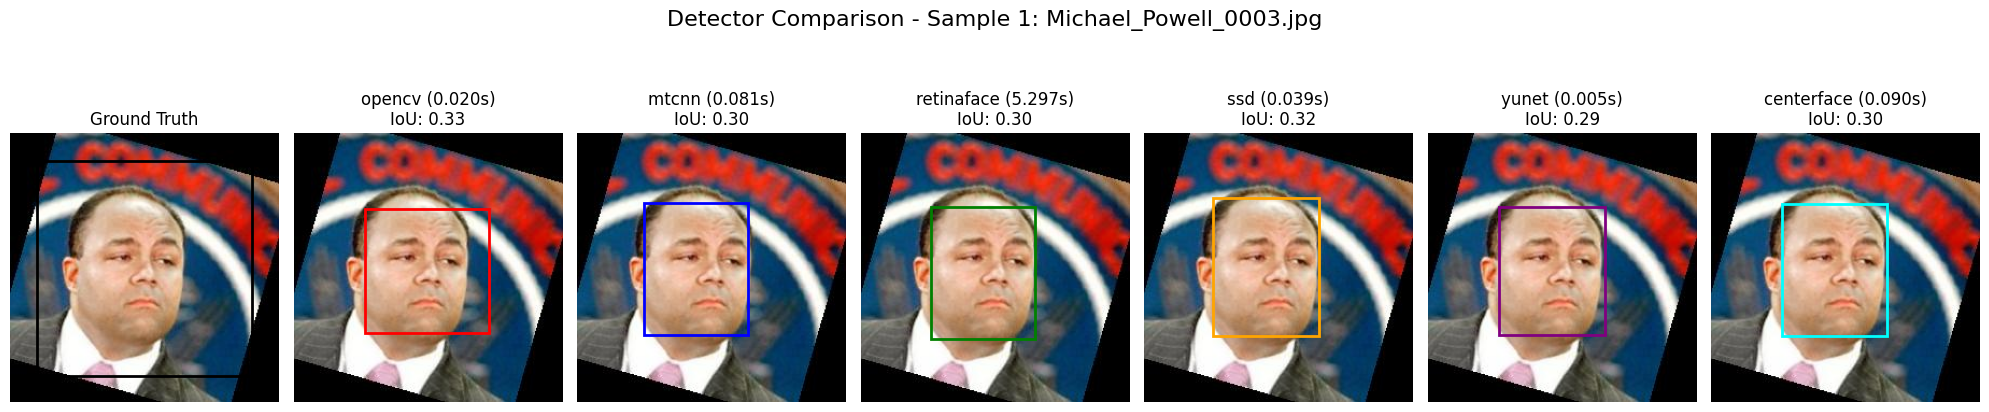

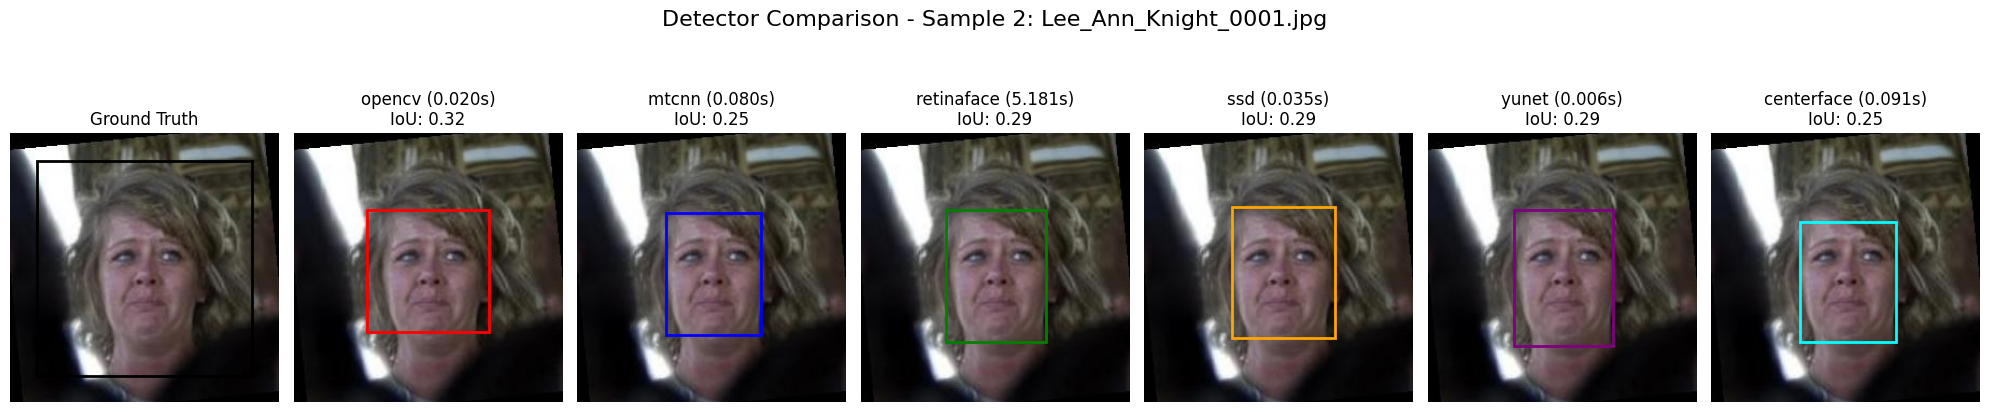

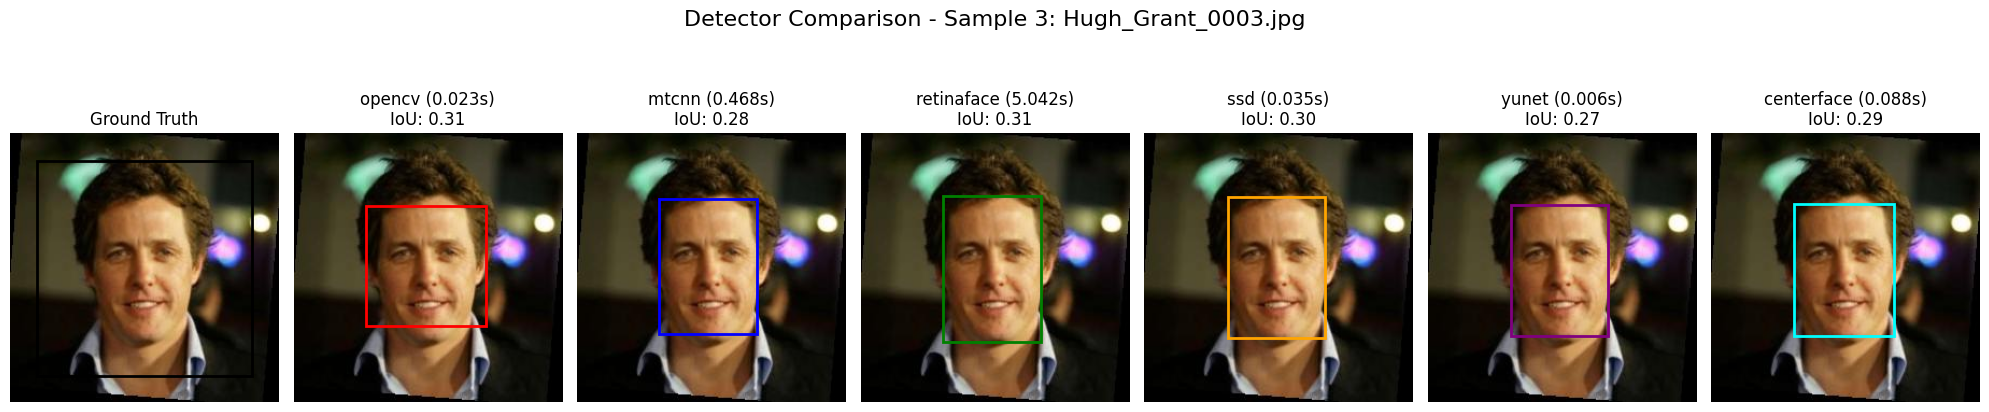

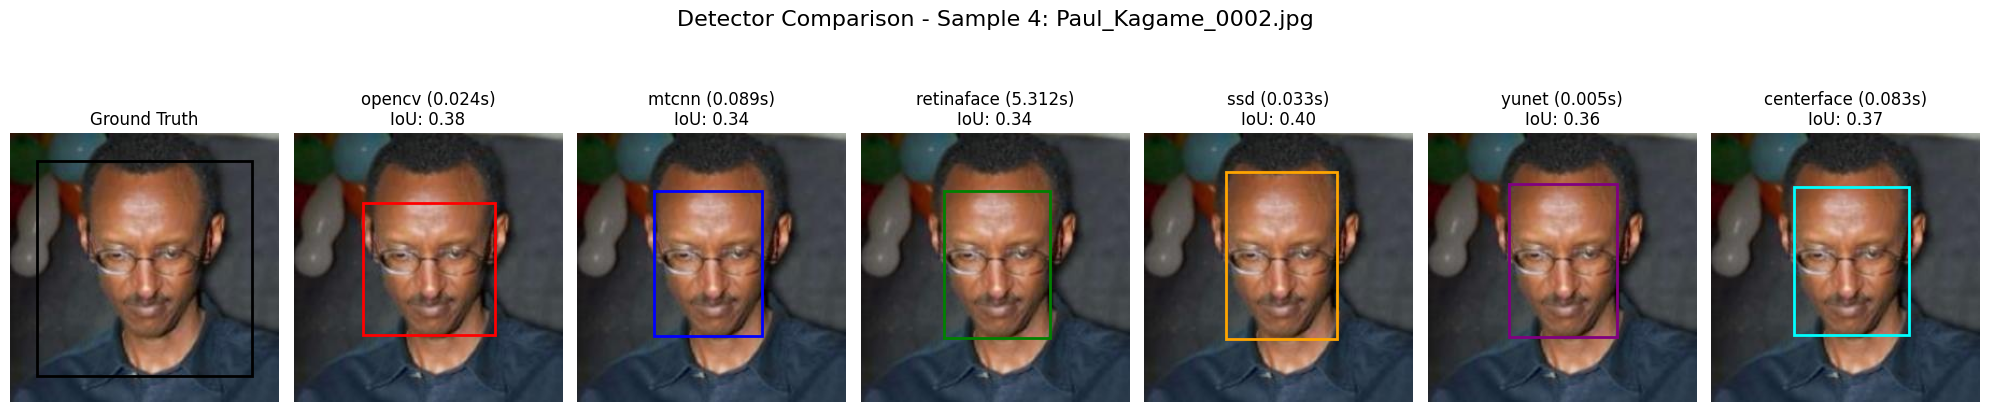

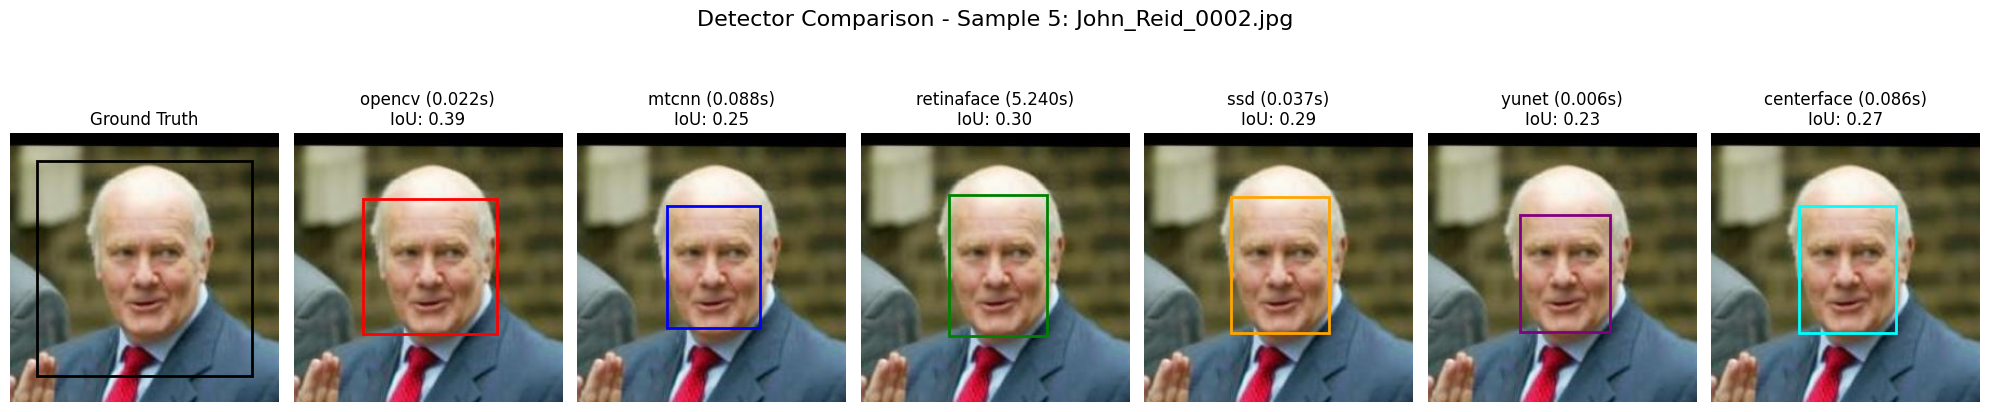

✅ Visualization complete!


({'lfw-deepfunneled\\Natalie_Coughlin\\Natalie_Coughlin_0004.jpg': [{'bbox': [25,
     25,
     200,
     200],
    'confidence': 1.0,
    'type': 'single_face'}],
  'lfw-deepfunneled\\Roger_Federer\\Roger_Federer_0002.jpg': [{'bbox': [25,
     25,
     200,
     200],
    'confidence': 1.0,
    'type': 'single_face'}],
  'lfw-deepfunneled\\Madeleine_Albright\\Madeleine_Albright_0001.jpg': [{'bbox': [25,
     25,
     200,
     200],
    'confidence': 1.0,
    'type': 'single_face'}],
  'lfw-deepfunneled\\Emma_Watson\\Emma_Watson_0002.jpg': [{'bbox': [25,
     25,
     200,
     200],
    'confidence': 1.0,
    'type': 'single_face'}],
  'lfw-deepfunneled\\Barbara_Bodine\\Barbara_Bodine_0001.jpg': [{'bbox': [25,
     25,
     200,
     200],
    'confidence': 1.0,
    'type': 'single_face'}],
  'lfw-deepfunneled\\Kimberly_Stewart\\Kimberly_Stewart_0001.jpg': [{'bbox': [25,
     25,
     200,
     200],
    'confidence': 1.0,
    'type': 'single_face'}],
  'lfw-deepfunneled\\Francois_Bo

In [18]:

def visualize_detector_bounding_boxes(test_annotations, images_dir, detectors=None, num_samples=3):
 
    import matplotlib.pyplot as plt
    import matplotlib.patches as patches
    from deepface import DeepFace
    import random
    import time
    
    if detectors is None:
        detectors = ["opencv", "mtcnn", "retinaface", "ssd", "yunet", "centerface"]
    
    colors = {
        "opencv": "red",
        "mtcnn": "blue",
        "retinaface": "green",
        "ssd": "orange",
        "yunet": "purple",
        "centerface": "cyan",
        "ground_truth": "black"
    }
    
    sample_keys = list(test_annotations.keys())
    if len(sample_keys) > num_samples:
        sample_keys = random.sample(sample_keys, num_samples)
    
    print(f"🔍 Visualizing detector bounding boxes on {num_samples} sample images...")
    
    for idx, img_key in enumerate(sample_keys):
        full_img_path = os.path.join(images_dir, img_key)
        
        if not os.path.exists(full_img_path):
            print(f"Image not found: {full_img_path}")
            continue
        
        img = cv2.imread(full_img_path)
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        fig, axes = plt.subplots(1, len(detectors) + 1, figsize=(20, 5))
        fig.suptitle(f"Detector Comparison - Sample {idx+1}: {os.path.basename(img_key)}", fontsize=16)
        
        axes[0].imshow(img_rgb)
        axes[0].set_title("Ground Truth")
        
        gt_bbox = test_annotations[img_key][0]['bbox']
        x, y, w, h = gt_bbox
        rect = patches.Rectangle((x, y), w, h, linewidth=2, edgecolor=colors["ground_truth"], facecolor="none")
        axes[0].add_patch(rect)
        axes[0].axis("off")
        
        for i, detector in enumerate(detectors):
            detector_img = img_rgb.copy()
            
            try:
                start_time = time.time()
                
                detections = DeepFace.extract_faces(
                    img_path=full_img_path,
                    detector_backend=detector,
                    enforce_detection=False,
                    align=False
                )
                
                detection_time = time.time() - start_time
                
                axes[i+1].imshow(detector_img)
                axes[i+1].set_title(f"{detector} ({detection_time:.3f}s)")
                
                if len(detections) > 0:
                    for detection in detections:
                        face_box = detection.get("facial_area", {})
                        if face_box:
                            x = face_box.get("x", 0)
                            y = face_box.get("y", 0)
                            w = face_box.get("w", 0)
                            h = face_box.get("h", 0)
                            
                            rect = patches.Rectangle((x, y), w, h, linewidth=2, edgecolor=colors[detector], facecolor="none")
                            axes[i+1].add_patch(rect)
                
                if len(detections) > 0:
                    try:
                        # Get the first detection for IoU calculation
                        face_box = detections[0].get("facial_area", {})
                        if face_box:
                            detected_box = [
                                face_box.get("x", 0),
                                face_box.get("y", 0),
                                face_box.get("w", 0),
                                face_box.get("h", 0)
                            ]
                            
                            def calculate_iou(box1, box2):
                                x1, y1, w1, h1 = box1
                                x2, y2, w2, h2 = box2
                                
                                box1_coords = [x1, y1, x1 + w1, y1 + h1]
                                box2_coords = [x2, y2, x2 + w2, y2 + h2]
                                
                                x_left = max(box1_coords[0], box2_coords[0])
                                y_top = max(box1_coords[1], box2_coords[1])
                                x_right = min(box1_coords[2], box2_coords[2])
                                y_bottom = min(box1_coords[3], box2_coords[3])
                                
                                if x_right < x_left or y_bottom < y_top:
                                    return 0.0
                                
                                intersection = (x_right - x_left) * (y_bottom - y_top)
                                
                                area1 = w1 * h1
                                area2 = w2 * h2
                                union = area1 + area2 - intersection
                                
                                return intersection / union if union > 0 else 0.0
                            
                            iou = calculate_iou(gt_bbox, detected_box)
                            axes[i+1].set_title(f"{detector} ({detection_time:.3f}s)\nIoU: {iou:.2f}")
                    except Exception as e:
                        pass
                        
            except Exception as e:
                axes[i+1].text(0.5, 0.5, f"Error: {str(e)[:50]}...", 
                              ha='center', va='center', transform=axes[i+1].transAxes)
            
            axes[i+1].axis("off")
        
        plt.tight_layout()
        plt.show()
        
    print("✅ Visualization complete!")

def compare_detector_bounding_boxes(num_samples=3):
    print("Setting up LFW dataset...")
    lfw_setup = LFWDatasetSetup()
    test_annotations, images_dir = lfw_setup.setup_complete_dataset()
    
    if test_annotations is None:
        print("❌ Failed to setup LFW dataset")
        return
        
    detectors = ["opencv", "mtcnn", "retinaface", "ssd", "yunet", "centerface"]
    
    visualize_detector_bounding_boxes(
        test_annotations=test_annotations,
        images_dir=images_dir,
        detectors=detectors,
        num_samples=num_samples
    )
    
    return test_annotations, images_dir

compare_detector_bounding_boxes(num_samples=5)

Setting up LFW dataset...
🚀 Setting up LFW dataset for single-face detection testing...
🔍 Scanning images...
✅ Found 13233 images
✅ Created annotations for 13233 images

📈 LFW Dataset Statistics:
  Total images: 13233
  Total faces: 13233
  Faces per image: 1.00
  Average image size: 250 x 250
  Average face area: 40000 pixels


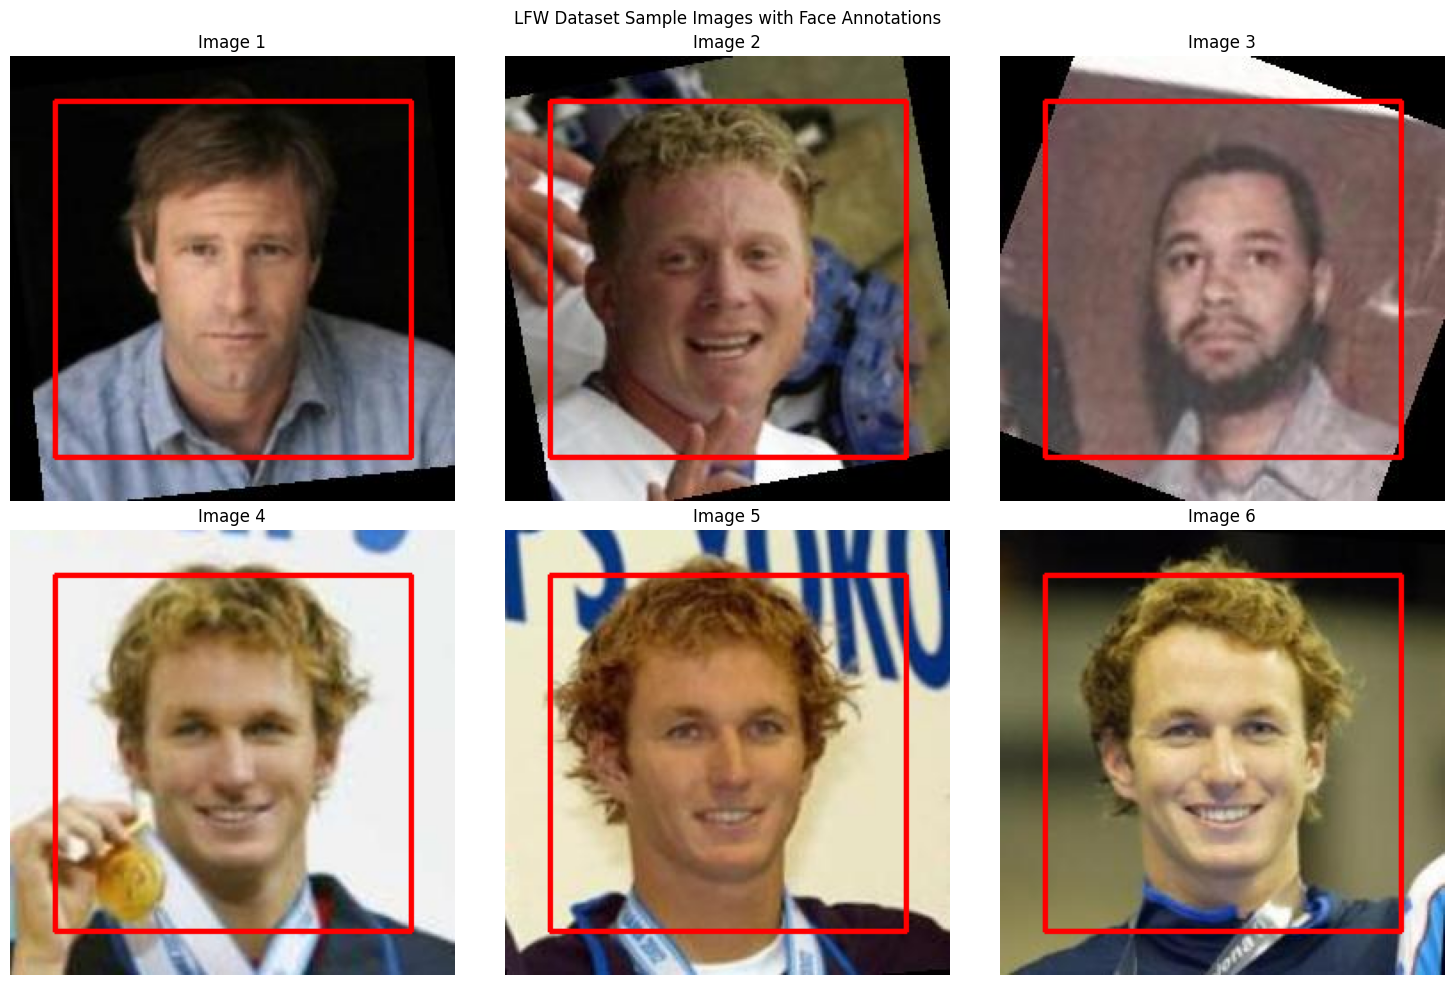

📊 Dataset split:
  Training images: 10586
  Testing images: 2647
✅ LFW dataset setup complete!
📍 Images location: data/lfw/lfw-deepfunneled

STARTING DEEPFACE DETECTOR PERFORMANCE TEST
STARTING DEEPFACE DETECTOR PERFORMANCE TEST
🚀 Starting comprehensive detector testing...
📊 Testing on 30 images

🔍 Testing opencv detector...
  Progress: 0/30 images processed
  Progress: 20/30 images processed
  ✅ opencv completed:
    - Avg Detection Time: 0.023s
    - Throughput: 42.92 images/sec
    - Success Rate: 1.000
    - Error Rate: 0.000

🔍 Testing mtcnn detector...
  Progress: 0/30 images processed
  Progress: 20/30 images processed
  ✅ mtcnn completed:
    - Avg Detection Time: 0.090s
    - Throughput: 11.12 images/sec
    - Success Rate: 1.000
    - Error Rate: 0.000

🔍 Testing retinaface detector...
  Progress: 0/30 images processed
  Progress: 20/30 images processed
  ✅ retinaface completed:
    - Avg Detection Time: 6.095s
    - Throughput: 0.16 images/sec
    - Success Rate: 1.000
    -


🏆 Best Detector Analysis:
  ⚡ Fastest: yunet (0.009s)
  🚀 Highest Throughput: yunet (113.72 img/sec)
  🎯 Most Reliable: opencv (1.000)
  ✅ Least Errors: opencv (0.000)
  🏆 Best Overall (Speed + Reliability): yunet (Score: 0.996)


In [16]:
def run_deepface_test():
    print("Setting up LFW dataset...")
    lfw_setup = LFWDatasetSetup()
    test_annotations, images_dir = lfw_setup.setup_complete_dataset(visualize=True)
    
    if test_annotations is None:
        print("❌ Failed to setup LFW dataset")
        return
    
    print("\n" + "="*60)
    print("STARTING DEEPFACE DETECTOR PERFORMANCE TEST")
    print("="*60)
    
    detector_test = DeepFaceDetectorTest(test_annotations, images_dir)
    
    # Test with 50 images
    results = detector_test.test_all_detectors(max_images=30)
    
    detector_test.create_performance_plots()
    
    detector_test.get_best_detector()
    
    return detector_test

test_instance = run_deepface_test()